In [2]:
import tensorflow as tf
import numpy as np
import os.path
import joblib
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D, RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(tf.__version__)

Num GPUs: 1
2.8.0


## Move the 100 images from the data set to the train, validation and the test set.

In [3]:
os.chdir(os.path.dirname(os.path.abspath('model_covid.ipynb')))
if os.path.isdir('train/covid') is False:
    os.makedirs('train/covid')
    os.makedirs('train/normal')
    os.makedirs('valid/covid')
    os.makedirs('valid/normal')
    os.makedirs('test/covid')
    os.makedirs('test/normal')
    
    for c in random.sample(glob.glob('covid/*'), 80):
        shutil.move(c, 'train/covid')
    for c in random.sample(glob.glob('normal/*'), 80):
        shutil.move(c, 'train/normal')
    for c in random.sample(glob.glob('covid/*'), 10):
        shutil.move(c, 'valid/covid')
    for c in random.sample(glob.glob('normal/*'), 10):
        shutil.move(c, 'valid/normal')
    for c in random.sample(glob.glob('covid/*'), 10):
        shutil.move(c, 'test/covid')
    for c in random.sample(glob.glob('normal/*'), 10):
        shutil.move(c, 'test/normal')

# Data Augmentation

1. Preprocess the data set to feed the images to Keras ImageDataGenerator which generates 10 augemented images for each image.
2. Save the augmented images in the train, validation and test set.

In [4]:
gen = ImageDataGenerator(rotation_range=10, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.1, 
                         zoom_range=0.1,
                         channel_shift_range=10.,
                         horizontal_flip=True)

In [5]:
def rgba2rgb(rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B

    return np.asarray( rgb, dtype='uint8' )

## Preprocessing the data set

In [6]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = plt.imread(os.path.join(folder,filename))
        img = img * 255
        if img is not None:
            if len(img.shape) > 2 and img.shape[2] == 4:
                img = rgba2rgb(img)
                img = np.expand_dims(img, 0)
            elif len(img.shape) == 2:
                img = np.expand_dims(img, 0)
                img = np.expand_dims(img, 3)
            elif len(img.shape) <= 3:
                img = np.expand_dims(img, 0)
            images.append(img)
    return images

In [4]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
covid = load_images_from_folder('train/covid')
normal = load_images_from_folder('train/normal')

In [9]:
def augment_images(images, save_to_dir):
    for idx in range(len(images)):
        aug_iter = gen.flow(images[idx], save_to_dir=save_to_dir, save_prefix='aug-image-', save_format='jpeg')
        aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

In [11]:
augment_images(covid, 'train/covid')
augment_images(normal, 'train/normal')

Move the images to the train, validation and test set.

In [12]:
for c in random.sample(glob.glob('train/covid/*'), 170):
    shutil.move(c, 'valid/covid')
for c in random.sample(glob.glob('train/normal/*'), 170):
    shutil.move(c, 'valid/normal')
for c in random.sample(glob.glob('train/covid/*'), 170):
    shutil.move(c, 'test/covid')
for c in random.sample(glob.glob('train/normal/*'), 170):
    shutil.move(c, 'test/normal')

In [5]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

## Use the vgg16 prepocesser to preprocess the images which resizes and reshapes the images to feed the model

In [6]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10, classes=['covid', 'normal'])
 
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10, classes=['covid', 'normal'])

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=10, classes=['covid', 'normal'], shuffle=False)

Found 1004 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 360 images belonging to 2 classes.


In [7]:
assert test_batches.n == 360
assert train_batches.n == 1004
assert valid_batches.n == 360

In [8]:
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

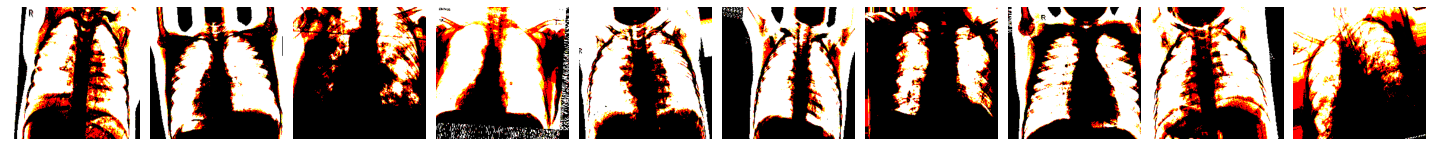

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [9]:
plotImages(imgs)
print(labels)

## Filters

The higher the number of filters, the higher the number of abstractions that your Network is able to extract from image data. The reason why the number of filters is generally ascending is that at the input layer the Network receives raw pixel data. Raw data are always noisy, and this is especially true for image data.

Because of this, we let CNNs extract first some relevant information from noisy, "dirty" raw pixel data. Once the useful features have been extracted, then we make the CNN elaborate more complex abstractions on it.

That is why the number of filters usually increases as the Network gets deeper, even though it doesn't necessarily have to be like that.


## Kernel Size

Convolutional neural networks work on 2 assumptions -

Low level features are local
What's useful in one place will also be useful in other places
Kernel size should be determined by how strongly we believe in those assumptions for the problem at hand.

In one extreme case where we have 1x1 kernels, we are essentially saying low level features are per-pixel, and they don't affect neighbouring pixels at all, and that we should apply the same operation to all pixels.

In the other extreme, we have kernels the size of the entire image. In this case the CNN essentially becomes fully connected, and stops being a CNN, and we are no longer making any assumption on low level feature locality.

In [10]:
# Without dropwout accuracy was at 99.4% and validation at 95.3%, with dropout accuracy increased to 100% and validation to 96.94%.
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dropout(0.25),
    Dense(units=2, activation='softmax'),
])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-13 15:08:55.177206: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-13 15:08:55.177342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [36]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [12]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

/Users/nandangrover/miniforge3/envs/deeplearning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Model is saved in the covid_model.h5 file and the history is saved in the covid_history.pkl file.

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

if os.path.isfile('models/covid_model.h5'):
    model = load_model('models/covid_model.h5')
    history = joblib.load('models/history/covid_history.pkl')
else:
    history = model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2, callbacks=[callback])
    joblib.dump(history, 'models/history/covid_history.pkl')
    
    model.save('models/covid_model.h5')

# Tracking Convergence

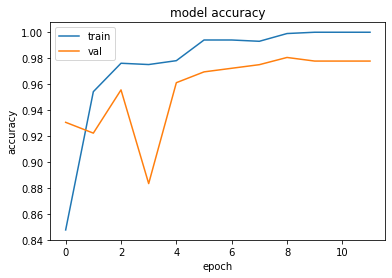

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

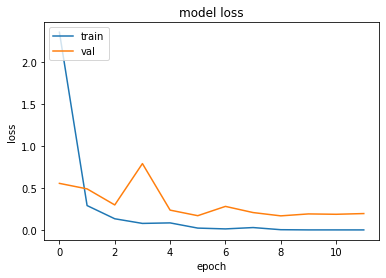

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

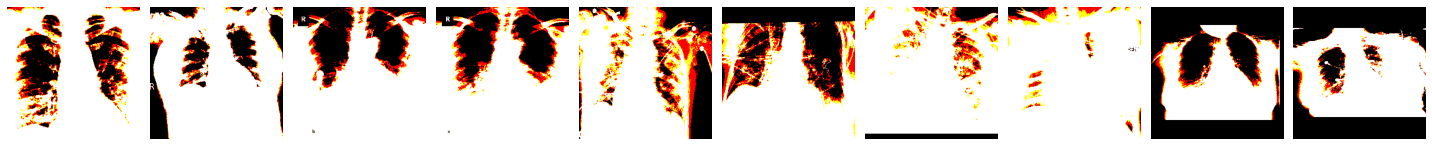

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [16]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [17]:
predictions = model.predict(x=test_batches, verbose=0)

2022-05-13 15:09:13.553943: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-13 15:09:13.594959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [18]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [19]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [20]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}%".format(cm[i, j] * 100),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
test_batches.class_indices

{'covid': 0, 'normal': 1}

Confusion matrix for the model is shown below, where the diagonal elements are the true positives, the off-diagonal elements are the false positives.

Normalized confusion matrix
[[0.97222222 0.02777778]
 [0.01111111 0.98888889]]


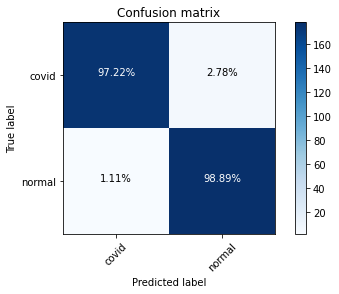

In [22]:
cm_plot_labels = ['covid', 'normal']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix', normalize= True)

In [23]:
from sklearn import metrics

print(metrics.classification_report(test_batches.classes, np.argmax(predictions, axis=-1), target_names=cm_plot_labels))

              precision    recall  f1-score   support

       covid       0.99      0.97      0.98       180
      normal       0.97      0.99      0.98       180

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360

